# Intro to regression

Regression is a generic task for statistical models that predict **continuous** properties. Contrast that with models that predict discrete properties or classes, which perform _classification_. We'll cover classification in another notebook.

In this notebook we'll ask: what's the least amount we can do to build and use a regression model?

First we need a task. Let's try to predict a well log from another. The steps are:

1. Load data.
1. Make `X` and `y`.
1. Standardize the data.
1. Train a model.
1. Evaluate the result.
1. Adjust and repeat...

---

## Load data

In [4]:
import numpy as np

ds = np.DataSource('../data/')

data = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/GR-NPHI-RHOB-DT.npy', mode='rb'))

data[:10]

array([[102.70370002,   0.2455    ,   2.5965    ,  82.53010001],
       [ 91.31870001,   0.2432    ,   2.5882    ,  81.7004    ],
       [104.75629998,   0.2406    ,   2.5755    ,  82.9246    ],
       [106.90440001,   0.2393    ,   2.5726    ,  81.796     ],
       [106.83279999,   0.2416    ,   2.5804    ,  81.1015    ],
       [110.3892    ,   0.2294    ,   2.5781    ,  82.4635    ],
       [113.18169999,   0.2516    ,   2.5609    ,  84.49229999],
       [104.60520001,   0.2543    ,   2.5911    ,  82.7202    ],
       [110.81879998,   0.2299    ,   2.6312    ,  82.8683    ],
       [102.89460002,   0.2547    ,   2.5796    ,  86.2192    ]])

We're going to start with the simplest possible problem: predicting the DT log (last column) from the RHOB log (second-to-last column).

## Make `X` and `y`

Let's make `X` (the density log, with SI units) and `y` (the DT log, transformed to velocity).

In [5]:
X = 1000 * data[: , -2].reshape(-1, 1)
y = 0.3048 * 1e6 / data[:, -1]

In [6]:
X.shape, y.shape

((71, 1), (71,))

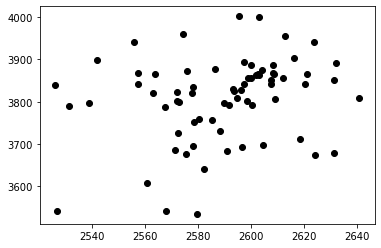

In [7]:
import matplotlib.pyplot as plt

plt.scatter(X, y, c='k')

## Standardize the data

Before doing linear regression, it's a good idea to transform the input to Z-score ('stnadardization').

In [12]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)

X = scaler.transform(X)

## Train a model

Now we can train a model:

In [13]:
from sklearn.linear_model import LinearRegression

est = LinearRegression().fit(X, y)

The weights or coefficients are now non-zero, so the model has learned something:

In [14]:
est.coef_, est.intercept_

(array([23.58596249]), 3807.625131412203)

Let's look at the model... there's no easy way to do this, unfortunately. We didn't withhold any blind data, so we have to either use `X`, or we can make some data. Let's do both:

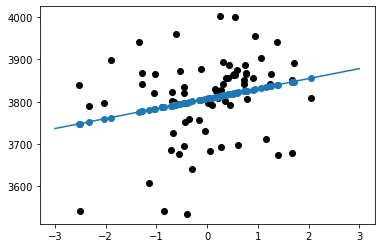

In [8]:
# Make a regularly sampled model.
X_model = np.linspace(-3, 3).reshape(-1, 1)
y_model = est.predict(X_model)

# Predict the training data.
y_pred = est.predict(X)

# Plot it all...
plt.scatter(X, y, c='k')
plt.scatter(X, y_pred)
plt.plot(X_model, y_model)
plt.show()

## Evaluate the model

How did we do?

In [9]:
from sklearn.metrics import r2_score, mean_squared_error

r2_score(y, est.predict(X))

0.0569913124407907

In [10]:
mean_squared_error(y, y_pred)

9204.797576590761

In [11]:
np.sqrt(mean_squared_error(y, y_pred))

95.94163630348797

<AxesSubplot:ylabel='Count'>

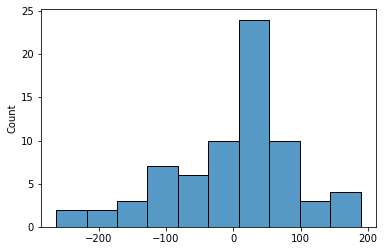

In [12]:
import seaborn as sns

residuals = y - y_pred

sns.histplot(residuals)

In [13]:
np.mean(residuals)

6.404892266006537e-14

## More dimensions!

We have 2 more features, making 3 in all. Now the model will be like:

$$ \hat{y} = w_0 x_0 + w_1 x_1 + w_2 x_2 + b $$

In [8]:
data[:10]

array([[102.70370002,   0.2455    ,   2.5965    ,  82.53010001],
       [ 91.31870001,   0.2432    ,   2.5882    ,  81.7004    ],
       [104.75629998,   0.2406    ,   2.5755    ,  82.9246    ],
       [106.90440001,   0.2393    ,   2.5726    ,  81.796     ],
       [106.83279999,   0.2416    ,   2.5804    ,  81.1015    ],
       [110.3892    ,   0.2294    ,   2.5781    ,  82.4635    ],
       [113.18169999,   0.2516    ,   2.5609    ,  84.49229999],
       [104.60520001,   0.2543    ,   2.5911    ,  82.7202    ],
       [110.81879998,   0.2299    ,   2.6312    ,  82.8683    ],
       [102.89460002,   0.2547    ,   2.5796    ,  86.2192    ]])

In [15]:
X2 = data[:, :3].reshape(-1, 3)

In [16]:
scaler = StandardScaler().fit(X2)

X2 = scaler.transform(X2)

In [17]:
est2 = LinearRegression().fit(X2, y)

y_pred2 = est2.predict(X2)

Let's see how this new model does:

In [18]:
r2_score(y, y_pred2)

0.5597900163150489

In [19]:
np.sqrt(mean_squared_error(y, y_pred2))

65.55098443267046

This seems to be a better model!

If we want to plot the linear model, we'll need to add a couple of dimensions to `X_model`; we can use the means of the other two columns.

In [20]:
X_model2 = np.array([0, 0, 1]) * X_model

We can try to look at the projection of this new model onto the original 2D plane of the problem. The real data is shown in black, and the original (bad) model in blue. The new model is shown in orange (with mean values for the other two dimensions).

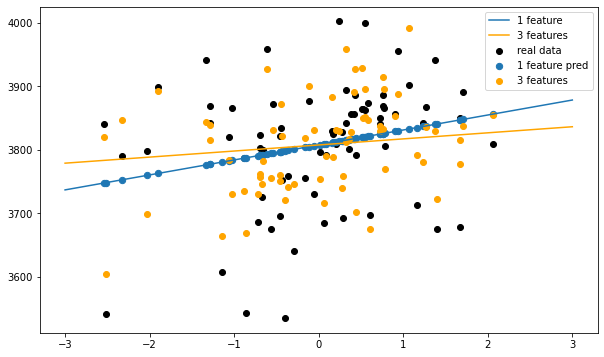

In [21]:
y_pred = est.predict(X)
y_model2 = est2.predict(X_model2)

plt.figure(figsize=(10, 6))
plt.scatter(X, y, c='k', label='real data')
plt.scatter(X, y_pred, c='C0', s=40, label='1 feature pred')
plt.scatter(X2[:, 2], y_pred2, c='orange', label='3 features')
plt.plot(X_model, y_model, 'C0', label='1 feature')
plt.plot(X_model2[:, 2], y_model2, 'orange', label='3 features')
plt.legend()
plt.show()

It's more instructive to look at the residuals:

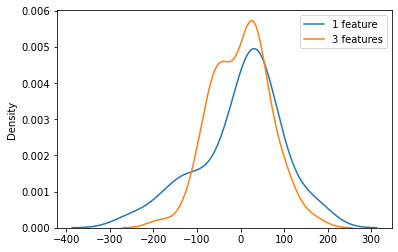

In [22]:
residuals2 = y - est2.predict(X2)

sns.kdeplot(residuals, label='1 feature')
sns.kdeplot(residuals2, label='3 features')
plt.legend()

---

&copy; 2020 Agile Scientific, licenced CC-BY